## Pruning and Quantization Practice

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ITU-AI-ML-in-5G-Challenge/MentoringSessions2022/blob/main/ML_model_compression.ipynb)

### Import preliminary libraries

In [1]:
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import pyplot
import time

from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

### Download Data

In [2]:
dataset_path = './data/diff_dataset.csv'
testset_path = './data/diff_testset.csv'

In [3]:
# read dataset
dataset = pd.read_csv(dataset_path)
testset = pd.read_csv(testset_path)

In [4]:
# drop unnamed column
dataset.drop(columns=['Unnamed: 0'], inplace=True)
testset.drop(columns=['Unnamed: 0'], inplace=True)

In [5]:
column = dataset.columns

X_train = dataset[column[:-1]]
X_test = testset[column[:-1]]
y_train = dataset[column[-1]]
y_test = testset[column[-1]]

X = pd.concat([X_train, X_test], axis=0, ignore_index=True, sort=False)
Y = pd.concat([y_train, y_test], axis=0, ignore_index=True, sort=False)

print(X.shape, Y.shape)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(3542, 996) (3542,)
(1861, 996) (1861,)
(1681, 996) (1681,)


In [6]:
#X_train = X_train.to_numpy()
#X_test = X_test.to_numpy()
#y_test = y_test.to_numpy()
#y_train = y_train.to_numpy()

### Model Building and Training

In [7]:
ss = StandardScaler()
std_X_train = ss.fit_transform(X_train)
std_X_test = ss.transform(X_test)

In [8]:
model = Sequential()

model.add(Dense(498,activation='sigmoid'))
model.add(Dense(249,activation='sigmoid'))
model.add(Dense(125,activation='sigmoid'))
model.add(Dense(62,activation='sigmoid'))
model.add(Dense(31,activation='sigmoid'))
model.add(Dense(15,activation='sigmoid'))

model.add(Dense(1)) 

2022-10-24 14:02:42.029246: I tensorflow/core/platform/cpu_feature_guard.cc:152] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-24 14:02:42.478327: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30999 MB memory:  -> device: 0, name: Tesla V100S-PCIE-32GB, pci bus id: 0000:48:00.0, compute capability: 7.0


In [9]:
model.compile(optimizer='rmsprop',loss='mse')

In [10]:
early_stop = EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=50)

In [11]:
model.fit(x=std_X_train,y=y_train,epochs=200,validation_data=(std_X_test,y_test),callbacks=[early_stop]) 

Epoch 1/200
59/59 [==============================] - 2s 7ms/step - loss: 20.9904 - val_loss: 26.8516
Epoch 2/200
59/59 [==============================] - 0s 6ms/step - loss: 12.4795 - val_loss: 20.0698
Epoch 3/200
59/59 [==============================] - 0s 5ms/step - loss: 8.6997 - val_loss: 15.9486
Epoch 4/200
59/59 [==============================] - 0s 5ms/step - loss: 6.4548 - val_loss: 12.8281
Epoch 5/200
59/59 [==============================] - 0s 5ms/step - loss: 5.1951 - val_loss: 11.0453
Epoch 6/200
59/59 [==============================] - 0s 5ms/step - loss: 4.8163 - val_loss: 10.3775
Epoch 7/200
59/59 [==============================] - 0s 5ms/step - loss: 4.7363 - val_loss: 10.1814
Epoch 8/200
59/59 [==============================] - 0s 5ms/step - loss: 4.6447 - val_loss: 9.9753
Epoch 9/200
59/59 [==============================] - 0s 5ms/step - loss: 4.5036 - val_loss: 9.6985
Epoch 10/200
59/59 [==============================] - 0s 7ms/step - loss: 4.2821 - val_loss: 9.1670


In [12]:
loss_df = pd.DataFrame(model.history.history)

<AxesSubplot:>

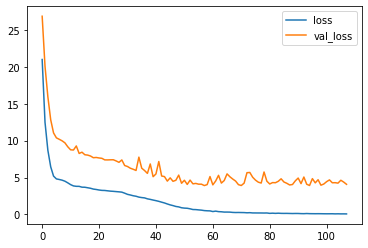

In [13]:
loss_df.plot()

In [14]:
start = time.time()
predictions = model.predict(std_X_test)
end = time.time()
print(f'Prediction time: {end-start}')

Prediction time: 0.1898343563079834


In [15]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [43]:
baseline_rmse = np.sqrt(mean_squared_error(y_test, predictions))

print(f'RMSE: {np.sqrt(mean_squared_error(y_test, predictions))}')
print(f'MAE: {mean_absolute_error(y_test, predictions)}')

RMSE: 2.2807117049256314
MAE: 1.8380790292897584


In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 498)               496506    
                                                                 
 dense_1 (Dense)             (None, 249)               124251    
                                                                 
 dense_2 (Dense)             (None, 125)               31250     
                                                                 
 dense_3 (Dense)             (None, 62)                7812      
                                                                 
 dense_4 (Dense)             (None, 31)                1953      
                                                                 
 dense_5 (Dense)             (None, 15)                480       
                                                                 
 dense_6 (Dense)             (None, 1)                 1

In [18]:
model.save('./saved_models/baseline_model.h5')

In [19]:
import os
os.path.getsize('./saved_models/baseline_model.h5')

5358424

## Model Pruning

In [20]:
import tensorflow_model_optimization as tfmot

In [21]:
prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

In [22]:
epochs = 30
batch_size = 32
end_step = 200 

In [23]:
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50, final_sparsity=0.80, begin_step=0, end_step=end_step)
                }

In [24]:
pruned_model = prune_low_magnitude(model,**pruning_params)

In [25]:
pruned_model.compile(optimizer='rmsprop',loss='mse')

In [26]:
pruned_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prune_low_magnitude_dense (  (None, 498)              992516    
 PruneLowMagnitude)                                              
                                                                 
 prune_low_magnitude_dense_1  (None, 249)              248255    
  (PruneLowMagnitude)                                            
                                                                 
 prune_low_magnitude_dense_2  (None, 125)              62377     
  (PruneLowMagnitude)                                            
                                                                 
 prune_low_magnitude_dense_3  (None, 62)               15564     
  (PruneLowMagnitude)                                            
                                                                 
 prune_low_magnitude_dense_4  (None, 31)               3

In [27]:
import tempfile

In [28]:
log_dir = tempfile.mkdtemp()
callbacks = [
    tfmot.sparsity.keras.UpdatePruningStep(),
    tfmot.sparsity.keras.PruningSummaries(log_dir=log_dir)
]

In [29]:
pruned_model.fit(x=std_X_train,y=y_train,epochs=epochs,validation_data=(std_X_test,y_test),callbacks=callbacks)

Epoch 1/30
59/59 [==============================] - 3s 10ms/step - loss: 0.0939 - val_loss: 4.2520
Epoch 2/30
59/59 [==============================] - 1s 12ms/step - loss: 5.9915 - val_loss: 30.0282
Epoch 3/30
59/59 [==============================] - 0s 8ms/step - loss: 13.5162 - val_loss: 19.2630
Epoch 4/30
59/59 [==============================] - 1s 9ms/step - loss: 10.4818 - val_loss: 20.6876
Epoch 5/30
59/59 [==============================] - 0s 8ms/step - loss: 9.8977 - val_loss: 18.3972
Epoch 6/30
59/59 [==============================] - 1s 9ms/step - loss: 8.4660 - val_loss: 16.5583
Epoch 7/30
59/59 [==============================] - 0s 8ms/step - loss: 7.3196 - val_loss: 15.0120
Epoch 8/30
59/59 [==============================] - 1s 9ms/step - loss: 6.3579 - val_loss: 13.6591
Epoch 9/30
59/59 [==============================] - 0s 8ms/step - loss: 5.5387 - val_loss: 12.5122
Epoch 10/30
59/59 [==============================] - 0s 8ms/step - loss: 4.8367 - val_loss: 11.4973
Epoch 

In [30]:
start = time.time()
predictions = pruned_model.predict(std_X_test)
end = time.time()
print(f'Prediction time: {end-start}')

Prediction time: 0.20441889762878418


In [31]:
print(f'RMSE: {np.sqrt(mean_squared_error(y_test, predictions))}')
print(f'MAEE: {mean_absolute_error(y_test, predictions)}')
pruned_rmse = np.sqrt(mean_squared_error(y_test, predictions))

RMSE: 2.2807117049256314
MAEE: 1.8380790292897584


In [32]:
model_for_export = tfmot.sparsity.keras.strip_pruning(pruned_model) #Once the model has been pruned, this method is used to restore the original model with the new sparse weights.
model_for_export.save('./saved_models/pruned_model.h5')

In [33]:
model_for_export.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 498)               496506    
                                                                 
 dense_1 (Dense)             (None, 249)               124251    
                                                                 
 dense_2 (Dense)             (None, 125)               31250     
                                                                 
 dense_3 (Dense)             (None, 62)                7812      
                                                                 
 dense_4 (Dense)             (None, 31)                1953      
                                                                 
 dense_5 (Dense)             (None, 15)                480       
                                                                 
 dense_6 (Dense)             (None, 1)                 1

In [36]:
start = time.time()
for _ in range(100):
    predictions = model_for_export.predict(std_X_test, verbose=0)
end = time.time()
pruned_pred_time = end-start
print(f'Pruned/Striped Prediction time: {end-start}')

start = time.time()
for _ in range(100):
    predictions = model.predict(std_X_test, verbose=0)
end = time.time()
baseline_pred_time = end-start
print(f'Baseline Prediction time: {end-start}')

Pruned/Striped Prediction time: 10.396554708480835
Baseline Prediction time: 11.02107572555542


In [39]:
import os
pruned_model_size = os.path.getsize('./saved_models/pruned_model.h5')
baseline_model_size = os.path.getsize('./saved_models/baseline_model.h5')
print(pruned_model_size)
print(baseline_model_size)

2676612
5358424


#### Pruned Model vs Baseline Model

In [56]:
print(f'Baseline Model Size: {baseline_model_size}')
print(f'Pruned Model Size: {pruned_model_size}') #percentage in comparison to baseline 
print('\n')
print(f'Baseline Model Prediction Time: {baseline_pred_time}')
print(f'Pruned Model Prediction Time: {pruned_pred_time}')
print('\n')
print(f'Baseline Model RMSE: {baseline_rmse}')
print(f'Pruned Model RMSE: {pruned_rmse}')

Baseline Model Size: 5.110191345214844
Pruned Model Size: 2.5526161193847656


Baseline Model Prediction Time: 11.02415919303894
Pruned Model Prediction Time: 10.520077466964722


Baseline Model RMSE: 2.0529216348001165
Pruned Model RMSE: 2.2786970059114444


## Post Training Quantization

In [40]:
import tensorflow as tf

In [41]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
quantized_and_pruned_tflite_model = converter.convert()

with open('./saved_models/pruned_quantized_model.tflite', 'wb') as f:
  f.write(quantized_and_pruned_tflite_model)

2022-10-24 13:50:53.256787: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /tmp/tmpodgzlz9f/assets


2022-10-24 13:50:54.093001: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:357] Ignored output_format.
2022-10-24 13:50:54.093041: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored drop_control_dependency.
2022-10-24 13:50:54.093888: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /tmp/tmpodgzlz9f
2022-10-24 13:50:54.095807: I tensorflow/cc/saved_model/reader.cc:78] Reading meta graph with tags { serve }
2022-10-24 13:50:54.095830: I tensorflow/cc/saved_model/reader.cc:119] Reading SavedModel debug info (if present) from: /tmp/tmpodgzlz9f
2022-10-24 13:50:54.102411: I tensorflow/cc/saved_model/loader.cc:230] Restoring SavedModel bundle.
2022-10-24 13:50:54.130988: I tensorflow/cc/saved_model/loader.cc:214] Running initialization op on SavedModel bundle at path: /tmp/tmpodgzlz9f
2022-10-24 13:50:54.145660: I tensorflow/cc/saved_model/loader.cc:321] SavedModel load for tags { serve }; Status: success: OK. Took 51776 m

In [42]:
pruned_quantized_model_size = os.path.getsize('./saved_models/pruned_quantized_model.tflite')

In [1]:
print(f'Baseline Model Size: {baseline_model_size}')
print(f'Pruned Model Size: {pruned_model_size}')
print(f'Pruned & Quantized Model Size: {pruned_quantized_model_size}')

In [41]:
# Load TFLite model and allocate tensors.
# How to predict with tfLite mode [Unzipping]
interpreter = tf.lite.Interpreter(model_content=quantized_and_pruned_tflite_model)
interpreter.allocate_tensors()# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
input_shape = input_details[0]['shape']
predictions = []
for i in range(len(std_X_test)):
    input_data = std_X_test[i]
    input_data = np.expand_dims(input_data, axis=0).astype(np.float32)

    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])
    predictions.append(output_data)

In [49]:
predictions = np.array(predictions).reshape(-1, 1)
pruned_quantized_rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f'RMSE: {np.sqrt(mean_squared_error(y_test, predictions))}')
print(f'MAEE: {mean_absolute_error(y_test, predictions)}')

RMSE: 2.2861918048050667
MAEE: 1.8262067446745556


In [50]:
print(f'Baseline Model RMSE: {baseline_rmse}')
print(f'Pruned Model RMSE: {pruned_rmse}')
print(f'Pruned & Quantized Model RMSE: {pruned_quantized_rmse}')

Baseline Model RMSE: 2.0529216348001165
Pruned Model RMSE: 2.2786970059114444
Pruned & Quantized Model RMSE: 2.2861918048050667


#### Quantized & Pruned Model vs Pruned Model vs Baseline Model

In [ ]:
print(f'Baseline Model Size: {baseline_model_size} ')
print(f'Pruned Model Size: {pruned_model_size} ')
print(f'Quantized & Pruned Model Size: {pruned_quantized_model_size} ')

print(f'Baseline Model Prediction Time: {baseline_pred_time}')
print(f'Pruned Model Prediction Time: {pruned_pred_time}')

print(f'Baseline Model RMSE: {baseline_rmse}')
print(f'Pruned Model RMSE: {pruned_rmse}')